In [1]:
import matplotlib as mpl
from matplotlib import pyplot as plt
plt.style.use("/home/kjeong/.config/matplotlib/custom.mplstyle")
plt.rcParams["text.latex.preamble"] = r'\usepackage{siunitx}\sisetup{detect-all}\usepackage{cmbright}\usepackage{amsmath}'#\usepackage{sansmath}\sansmath
plt.rcParams["font.family"] = 'sans-serif'
plt.rcParams["font.sans-serif"] = 'cmbright'

import dill
import numpy as np
import pandas as pd
from time import time
ntraj = 28*28*24
length = 1000
lag_ls = [100, 200, 400, 600, 800, 900]
lag=400

import scipy.constants as scicon
kbT_kJ=scicon.gas_constant*303.15*1e-3 #kJ/mol
kbT_kcal=scicon.gas_constant*303.15*1e-3/4.184 #kcal/mol
def P2pmf(arr):
    #Maximum probability is set to one (1)
    #Minimum pmf is set to zero
    return -kbT_kcal*np.log(arr/np.max(arr))
#is_range = [0.05, 0.15]

In [2]:
cvs_df = pd.read_pickle("/project/dinner/kjeong/insulin/pipeline/step7_5ns/step1_cvs_state/cvs_df.pkl")
dim_arr = np.load("/project/dinner/kjeong/insulin/pipeline/step7_5ns/step1_cvs_state/AB_arr/dim_arr.npy")
mon_arr = np.load("/project/dinner/kjeong/insulin/pipeline/step7_5ns/step1_cvs_state/AB_arr/mon_arr.npy")
other_arr = np.load("/project/dinner/kjeong/insulin/pipeline/step7_5ns/step1_cvs_state/AB_arr/other_arr.npy")

#b. Extra features by combining previously computed ones
phi_alpha = cvs_df.loc[:,'phi-alpha'].to_numpy()
phi_alpha_lb = np.average(phi_alpha[dim_arr])-180
phi_alpha[phi_alpha<phi_alpha_lb] = phi_alpha[phi_alpha<phi_alpha_lb]+360

phi_alpha_me = cvs_df.loc[:,'phi-alpha(me)'].to_numpy()
phi_alpha_me_lb = np.average(phi_alpha_me[dim_arr])-180
phi_alpha_me[phi_alpha_me<phi_alpha_me_lb] = phi_alpha_me[phi_alpha_me<phi_alpha_me_lb]+360

phi_beta = cvs_df.loc[:,'phi-beta(me)'].to_numpy()
phi_beta_lb = np.average(phi_beta[dim_arr])-180
phi_beta[phi_beta<phi_beta_lb] = phi_beta[phi_beta<phi_beta_lb]+360

cvs_df['gammac'] = cvs_df['gamma1c'] + cvs_df['gamma2c']
cvs_df["native_all"] = cvs_df.loc[:, "native"] + cvs_df.loc[:, "semi-native"]
"""
key = 'phi-open'
plt.hist(cvs_df.loc[dim_arr, key], alpha=0.5, density=True)
plt.hist(cvs_df.loc[other_arr, key], alpha=0.5, density=True)
plt.hist(cvs_df.loc[mon_arr, key], alpha=0.2, density=True)
"""

"\nkey = 'phi-open'\nplt.hist(cvs_df.loc[dim_arr, key], alpha=0.5, density=True)\nplt.hist(cvs_df.loc[other_arr, key], alpha=0.5, density=True)\nplt.hist(cvs_df.loc[mon_arr, key], alpha=0.2, density=True)\n"

In [3]:
# Load US weight
P_beagle=f"/beagle3/dinner/kjeong"
us_path=f"{P_beagle}/insulin_backedup/NVT_US_ins/cvs"
psis=np.load(f'{us_path}/input_PMFdata/t_50/Psis50.npy')
z=np.load(f'{us_path}/input_PMFdata/t_50/Zs50.npy')

nwindow, nframe_us = psis.shape[:-1]
nwindow_ax = int(np.sqrt(nwindow))
ntraj_w=24
ntraj = nwindow*ntraj_w
weight_us_all = np.zeros((nwindow, nframe_us))# (window, nframe per each traj 1050 )
for i0 in range(nwindow):
    psi_sum = np.sum(psis[i0], axis=1)
    weight_us_all[i0] = z[i0]/(psi_sum*nframe_us)
#/project/dinner/kjeong/insulin/pipeline/step0_catdcd
weight_us = weight_us_all[:, 42:1050:42]

w_us = np.repeat(np.ravel(weight_us), length).reshape(ntraj, length)
w_us[:,-lag:]=0
w_us = w_us/np.sum(w_us)                

In [4]:
workdir = "/project/dinner/kjeong/insulin/pipeline/step7_5ns"
state_arr = np.load(f"{workdir}/step1_cvs_state/state_arr.npy")
with open(f"{workdir}/step3_lag_mem/output/qf_unq_mem.pkl", "rb") as f:
    qf_unq_mem = dill.load(f)

k_tmp, st_arr, qf_unq = 600, state_arr[3,0], qf_unq_mem[3][0, lag_ls.index(lag), [0,1]]
cvs_df["state"] = st_arr
st_uq, st_id, st_inv = np.unique(st_arr, return_index=True, return_inverse=True)
for i_mem, q_tmp in enumerate(qf_unq):
    arr = np.zeros(ntraj*length)
    for i_st, q_val in enumerate(q_tmp):
        arr[st_inv==i_st] = q_val
    cvs_df[f"q_k{k_tmp}_mem{i_mem}"] = arr

In [5]:
inv_rate_arr = np.load(f"{workdir}/step4_rate/mem/inv_rate_arr.npy")
rate = 1/inv_rate_arr[3, 0, 2, 1]

In [6]:
inv_rate_arr[3, 0, 2, 1]

0.07250196401556214

In [7]:
avg_df = pd.DataFrame({
        "q_k600_mem0": qf_unq_mem[3][0, lag_ls.index(lag), 0],
        "q_k600_mem1": qf_unq_mem[3][0, lag_ls.index(lag), 1],
        })

w_tmp = np.zeros(k_tmp)
key_ls = list(cvs_df.keys())
cvs_tmp = np.zeros((k_tmp, len(key_ls)))
for i_st in range(k_tmp):
    w_tmp[i_st] = np.ravel(w_us)[st_inv==i_st].sum()
    cvs_tmp[i_st] = cvs_df.loc[st_inv==i_st].mean().to_numpy()
avg_df['w_us'] = w_tmp
for i_key, key in enumerate(key_ls):
    avg_df[key] = cvs_tmp[:, i_key]

In [8]:
# define some colormaps
colors = mpl.colors.to_rgba_array(
    [
        "#364B9A",
        "#4A7BB7",
        "#6EA6CD",
        "#98CAE1",
        "#C2E4EF",
        "#EAECCC",
        "#FEDA8B",
        "#FDB366",
        "#F67E4B",
        "#DD3D2D",
        "#A50026",
    ]
)
cm_div = mpl.colors.LinearSegmentedColormap.from_list("", colors)

In [9]:
q_key = "q_k600_mem1" #"qf"
is_range = [0.12, 0.16] #[0.1, 0.2]
ts_range = [0.48, 0.52] #[0.45, 0.55]
mask_avg_is = (avg_df.loc[:, q_key]>is_range[0]) & (avg_df.loc[:, q_key]<is_range[1])
mask_avg_ts = (avg_df.loc[:, q_key]>ts_range[0]) & (avg_df.loc[:, q_key]<ts_range[1])
mask_cvs_is = (cvs_df.loc[:, q_key]>is_range[0]) & (cvs_df.loc[:, q_key]<is_range[1])
mask_cvs_ts = (cvs_df.loc[:, q_key]>ts_range[0]) & (cvs_df.loc[:, q_key]<ts_range[1])
is_color = cm_div(sum(is_range)/2)
ts_color = cm_div(sum(ts_range)/2)

In [10]:
out = np.load(f"{workdir}/step6_atpt/output/fine_flux_mem.npy")
flux = np.hstack([1, (1 - (1/out)/rate), 1])
flux= np.clip(flux, a_min=0, a_max=None)
avg_df["flux"]=flux

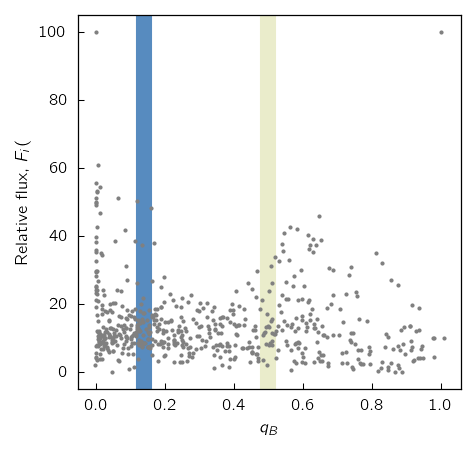

In [15]:
fig, ax = plt.subplots(1,1, figsize=(3.3, 3.3))
ax.plot(avg_df[q_key], 100*flux,'.', c='gray')
ax.axvspan(*is_range, color = is_color, alpha=1)
ax.axvspan(*ts_range, color = ts_color, alpha=1)
ax.set_xlabel(r"$q_B$")
ax.set_ylabel("Relative flux, "+r"$F_{i}$"+"(%)")
title_loc = f"{workdir}/figure/step7_fineflux.pdf"
#plt.savefig(title_loc)

'\nfor (_, mask_cg), m_cg, mask_tmp in zip(stid_cg.items(), m_cg_ls, [mask_avg_is, mask_avg_ts]):\n    for i in range(m_cg):\n        ax.scatter(avg_df[q_key][mask_tmp][mask_cg[i]], P2pmf(avg_df.loc[:, "w_us"])[mask_tmp][mask_cg[i]],\n                   s=50*avg_df.loc[:, "flux"][mask_tmp][mask_cg[i]], \n                   label=f"{i}", color= color_ls[i])\nax.legend()\n'

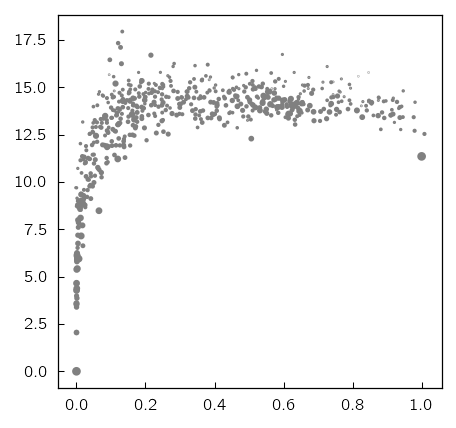

In [12]:
fig, ax = plt.subplots(1,1, figsize=(3.3, 3.3))
avg_df["pmf"] = P2pmf(avg_df.loc[:, "w_us"])
ax.scatter(avg_df[q_key], P2pmf(avg_df.loc[:, "w_us"]),
           s=10*avg_df.loc[:, "flux"], c='gray', zorder=0)
"""
for (_, mask_cg), m_cg, mask_tmp in zip(stid_cg.items(), m_cg_ls, [mask_avg_is, mask_avg_ts]):
    for i in range(m_cg):
        ax.scatter(avg_df[q_key][mask_tmp][mask_cg[i]], P2pmf(avg_df.loc[:, "w_us"])[mask_tmp][mask_cg[i]],
                   s=50*avg_df.loc[:, "flux"][mask_tmp][mask_cg[i]], 
                   label=f"{i}", color= color_ls[i])
ax.legend()
"""

In [13]:
print(np.sum(w_us))
print(np.sum((1-cvs_df.loc[:, q_key].to_numpy()) * np.ravel(w_us)))
print(np.sum(cvs_df.loc[:, q_key].to_numpy() * np.ravel(w_us)))

0.9999999999999996
0.9999840745581421
1.5925441857573517e-05


# CG

In [14]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import NearestNeighbors
from time import time

In [16]:
latex_lab = {
    "phi-alpha": r"$\tilde\Phi_\alpha\ (^\circ)$",
    "phi-alpha(me)": r"$\Phi_\alpha\ (^\circ)$",
    "phi-beta": r"$\tilde\Phi_\beta\ (^\circ)$",
    "phi-beta(me)": r"$\Phi_\beta\ (^\circ)$",
    "phi-open": r"$\bar\gamma\ (^\circ)$",
    "zip-Dist": r"$d_{\rm zip}\ {\rm (nm)}$",
    "R_com": r"$R_{\rm com}\ {\rm (nm)}$",
    "Q_Bagchi": r"$Q$",

    "All": r"$N_{\rm c}$",
    "native_all": r"$N_{\rm nat}$",
    #"semi-native": r"$N_{\rm natL}$",
    "non-native": r"$N_{\rm non}$",

    "Nwater(Interface)": r"$N_{\rm w}$",
    "Shared Nwater(Interface)": r"$N_{\rm {sw}}$",
    
    "beta": r"$\bar\beta\ {\rm (nm)}$",
    "alpha": r"$\bar\alpha\ {\rm (nm)}$",
    "gamma1": r"$\bar\gamma 2$",
    "gamma2": r"$\bar\gamma 1$",
    "betac": r"$\bar\beta_{c}$",
    "alphac": r"$\bar\alpha_{c}$",
    "gammac": r"$\bar\gamma_{c}$",
    "gamma1c": r"$\bar\gamma1_{c}$",
    "gamma2c": r"$\bar\gamma2_{c}$",

    "pmf": r"$\Delta G\ {\rm (kcal/mol)}$",
    "qf": r"$q_{B}$",
}

In [17]:
avg_df.keys()

Index(['q_k600_mem0', 'q_k600_mem1', 'w_us', 'phi-alpha', 'phi-alpha(me)',
       'phi-beta', 'phi-beta(me)', 'phi-open(ch1)', 'phi-open(ch2)', 'r_com',
       'theta', 'phi', 'Theta', 'Phi', 'Psi', 'Nwater(Interface)',
       'Shared Nwater(Interface)', 'R_com', 'CrossContact(7A)', 'zip-Dist',
       'phi-open', 'beta', 'alpha', 'gamma1', 'gamma2', 'betac', 'alphac',
       'gamma1c', 'gamma2c', 'zip-turn', 'zip-term', 'All', 'native',
       'semi-native', 'non-native', 'detach1', 'detach2', 'Q_Bagchi',
       'Hbond( 24-24' )', 'Hbond( 24-26' )', 'Hbond( 26-24' )',
       'Hbond( 26-26' )', 'Hbridge( 24-24' )', 'Hbridge( 24-26' )',
       'Hbridge( 26-24' )', 'Hbridge( 26-26' )', 'gammac', 'native_all',
       'state', 'flux', 'pmf'],
      dtype='object')

In [20]:
k_cg_ls = [4, 4]
str_div = ['phi-alpha(me)', 'phi-beta(me)', 'phi-open', 'zip-Dist']#, 'betac', 'alphac', 'gammac']#, 'gamma2c']
#str_div = ['phi-alpha(me)', 'phi-beta(me)', 'phi-open', 'betac', 'alphac', 'gamma1c', 'gamma2c']#, 'gamma2c']

cg_arrs = []
for k_cg, mask_tmp in zip(k_cg_ls, [mask_avg_is, mask_avg_ts]):
    feat_tmp = np.copy(avg_df.loc[mask_tmp, str_div].to_numpy())
    zip_id = str_div.index('zip-Dist')
    feat_tmp[:, zip_id] = np.abs(feat_tmp[:, zip_id])
    feat_tmp = (feat_tmp-np.mean(feat_tmp, axis=0))/np.std(feat_tmp, axis=0)
    #k-mean
    km = MiniBatchKMeans(n_clusters = k_cg, random_state=0).fit(feat_tmp)
    neighbors_arr = NearestNeighbors(n_neighbors=1).fit(km.cluster_centers_)
    cg_arr = neighbors_arr.kneighbors(feat_tmp, return_distance=False).squeeze()
    cg_arrs.append(cg_arr)

colors_cg = {
    "t": '#EE6677',
    "z": '#BBCC33',#228833',
    "r": '#0077BB',#'#4477AA',
    "o":'#DDAA33',
    "shifted": '#EE7733',
    "clamped": '#99DDFF'
}

(array([2., 1., 2., 1., 1., 0., 0., 3., 5., 1., 4., 1., 2., 1.]),
 array([ 95. ,  97.5, 100. , 102.5, 105. , 107.5, 110. , 112.5, 115. ,
        117.5, 120. , 122.5, 125. , 127.5, 130. ]),
 <BarContainer object of 14 artists>)

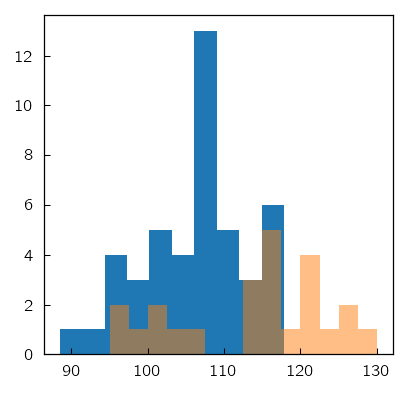

In [19]:
plt.hist(avg_df.loc[mask_avg_is, 'Nwater(Interface)'])
plt.hist(avg_df.loc[mask_avg_ts, 'Nwater(Interface)'], alpha =0.5, range=(95, 130), bins=14)

(array([21.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.]),
 array([0.        , 0.01563946, 0.03127892, 0.04691838, 0.06255783,
        0.07819729, 0.09383675, 0.10947621, 0.12511567, 0.14075513,
        0.15639459]),
 <BarContainer object of 10 artists>)

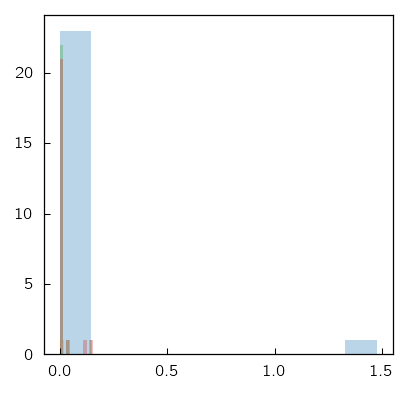

In [16]:
plt.hist(avg_df.loc[mask_avg_ts, "Hbond( 26-26' )"].to_numpy(), alpha =0.3)#, range=(95, 130), bins=14)
plt.hist(avg_df.loc[mask_avg_ts, "Hbond( 24-26' )"].to_numpy(), alpha =0.3)#, range=(95, 130), bins=14)
plt.hist(avg_df.loc[mask_avg_ts, "Hbond( 26-24' )"].to_numpy(), alpha =0.3)#, range=(95, 130), bins=14)
plt.hist(avg_df.loc[mask_avg_ts, "Hbond( 24-24' )"].to_numpy(), alpha =0.3)#, range=(95, 130), bins=14)

In [21]:
#CG_struct1
#cg_orders=[['o', 'z', 't', 'r'], ['z', 'r', 'o', 't']]
#CG_struct2
cg_orders=[['unzipped', 'splayed', 'twisted', 'rev-twisted'], ['unzipped', 'twisted', 'splayed', 'rev-twisted']]
str_div_proj = ['phi-alpha(me)', 'phi-beta(me)', 'phi-open', 'zip-Dist']#, 'betac', 'alphac']#, 'gamma1c', 'gamma2c']
colors_cg = {
    "twisted": '#CC3311',
    "unzipped": '#BBCC33',#228833',
    "rev-twisted": '#0077BB',#'#4477AA',
    "splayed":'#DDAA33',
    #"shifted": '#EE7733',
    #"clamped": '#99DDFF'
}

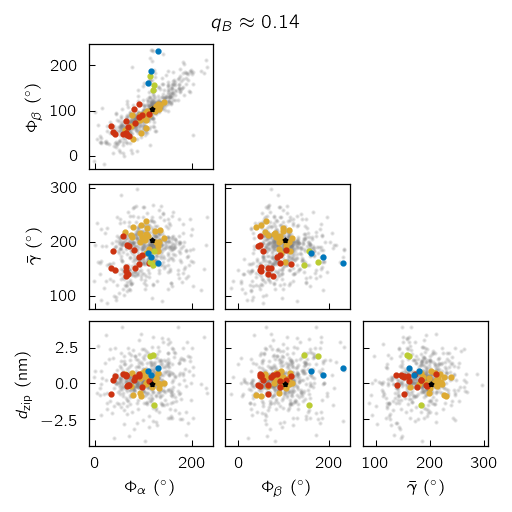

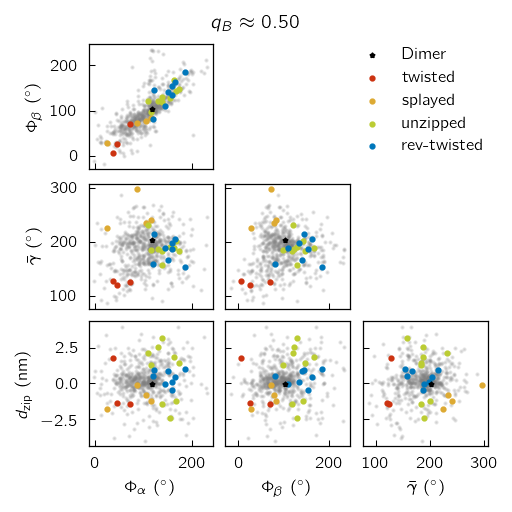

In [22]:
nstr = len(str_div_proj)
title = [is_range, ts_range]
for i_t, (k_cg, mask_tmp) in enumerate(zip(k_cg_ls, [mask_avg_is, mask_avg_ts])):
    colors = [colors_cg[cg_o] for cg_o in cg_orders[i_t]]
    cg_arr = cg_arrs[i_t]
    nrow = nstr-1; ncol = nstr-1
    fig_width = 3.3
    fig_height = fig_width * nrow / ncol
    fig, axs = plt.subplots(nstr-1, nstr-1, constrained_layout=True, figsize=(fig_width, fig_height), sharex='col', sharey='row')
    fig.suptitle(r"$q_B\approx\ $"+f"{(title[i_t][0]+title[i_t][1])/2:.2f}")
    for ir, y_str in enumerate(str_div_proj[1:]):
        for ic, x_str in enumerate(str_div_proj[:-1]):
            if ir>=ic:
                ax = axs[ir, ic]
                labels = [None]*5 if ic!=2 else ['Dimer', 'unzipped', 'twisted', 'splayed', 'rev-twisted']
                ax.scatter(avg_df.loc[0, x_str], avg_df.loc[0, y_str], color='black', marker='*', zorder=50, label=labels[0])
                ax.plot(avg_df.loc[:, x_str], avg_df.loc[:, y_str], '.', alpha=0.2, color='gray', zorder=0)
                #for i in range(k_cg):
                for i in [1,2,0,3]:
                    ax.scatter(avg_df.loc[mask_tmp].loc[cg_arr==i, x_str], avg_df.loc[mask_tmp].loc[cg_arr==i, y_str], alpha=1, c=colors[i], label=labels[i+1])
                if ir == nrow-1:
                    ax.set_xlabel(latex_lab[x_str])
                if ic == 0:
                    ax.set_ylabel(latex_lab[y_str])
            else:
                ax = axs[ir, ic]
                ax.axis('off')
    if i_t==1:
        lgd=fig.legend(bbox_to_anchor=(-2.03, 0.85, 3.02, 0.1), bbox_transform=fig.transFigure, ncol=1,fontsize=8)#, ncols=4)
    fname = "is" if i_t == 0 else "ts"
    title_loc = f"{workdir}/figure/step7_cgproj_{fname}_cm.pdf"
    #plt.savefig(title_loc)

In [17]:
"""
stid_cg = {} # Markov state index corresponding to each CG state (ise, [0, 1], tse, [0, 1, 2, 3, 4, 5, 6, 7])
for k_cg, cg_arr, level, mask_avg_tmp in zip(k_cg_ls, cg_arrs, ['IS', 'TS'], [mask_avg_is, mask_avg_ts]):
    stid_tmp = []
    for i0 in range(k_cg):
        stid_tmp.append(np.nonzero(mask_avg_tmp.to_numpy())[0][cg_arr==i0])
    stid_cg[level] = stid_tmp
"""

In [23]:
stid_cg = {} # Markov state index corresponding to each CG state (ise, [0, 1], tse, [0, 1, 2, 3, 4, 5, 6, 7])
for k_cg, cg_arr, level, mask_avg_tmp, cg_order in zip(k_cg_ls, cg_arrs, ['IS', 'TS'], [mask_avg_is, mask_avg_ts], cg_orders):
    for i0 in range(k_cg):
        stid_arr = np.nonzero(mask_avg_tmp.to_numpy())[0][cg_arr==i0]
        if "unzipped" in cg_order[i0]:
            mask_up = avg_df.loc[stid_arr, 'zip-Dist'].to_numpy() > 0
            mask_down = ~mask_up
            stid_cg[f"{level}-{cg_order[i0]}_up"] = stid_arr[mask_up]
            stid_cg[f"{level}-{cg_order[i0]}_down"] = stid_arr[mask_down]
        else:
            stid_cg[f"{level}-{cg_order[i0]}"] = stid_arr

In [22]:
"""
#These CVs are CVs that are not used for clustering but still interesting physical variables
#avg_df.loc[mask_avg_ts, [key for key in avg_df.keys() if 'Hbond' in key]+['Nwater(Interface)', 'Shared Nwater(Interface)', 'flux']]

print(np.count_nonzero(avg_df.loc[mask_avg_ts, "Hbond( 26-26' )"]>0.9))
print(np.count_nonzero(avg_df.loc[mask_avg_ts, 'Nwater(Interface)']<100))

state_ts_id = np.nonzero(mask_avg_ts.to_numpy())[0]

state_shifted_id = state_ts_id[avg_df.loc[mask_avg_ts, "Hbond( 26-26' )"]>0.9]
state_clamped_id = state_ts_id[avg_df.loc[mask_avg_ts, 'Nwater(Interface)']<100]

stid_cg["TS-shifted"] = state_shifted_id
stid_cg["TS-clamped"] = state_clamped_id
"""

1
3


In [47]:
"""
with open(f"{workdir}/step7_structure/output/step0_stid_cg.pkl", "wb") as f:
    dill.dump(stid_cg, f)
"""
"""
with open(f"{workdir}/step7_structure/stid_cg.pkl", "rb") as f:
    stid_cg = dill.load(f)
"""

In [23]:
with open(f"{workdir}/step7_structure/output/step0_stid_cg.pkl", "rb") as f:
    stid_cg_load = dill.load(f)

In [24]:
stid_cg_load

{'IS-unzipped_up': array([305, 484]),
 'IS-unzipped_down': array([506]),
 'IS-splayed': array([ 55,  70,  95, 112, 166, 295, 302, 318, 335, 352, 388, 409, 431,
        454, 473, 481, 513, 525, 535, 543, 570, 571, 572]),
 'IS-twisted': array([  7,  51,  88, 100, 110, 117, 129, 204, 264, 277, 289, 372, 426,
        440, 474, 530]),
 'IS-rev-twisted': array([181, 230, 253]),
 'TS-unzipped_up': array([  3,  64, 108, 167, 449, 483]),
 'TS-unzipped_down': array([ 17, 178, 393]),
 'TS-twisted': array([254, 447, 542]),
 'TS-splayed': array([113, 256, 275, 279]),
 'TS-rev-twisted': array([140, 194, 223, 238, 413, 501, 514, 568]),
 'TS-shfited': array([279]),
 'TS-clamped': array([223, 393, 514])}

In [24]:
stid_cg

{'IS-unzipped_up': array([305, 484]),
 'IS-unzipped_down': array([506]),
 'IS-splayed': array([ 55,  70,  95, 112, 166, 295, 302, 318, 335, 352, 388, 409, 431,
        454, 473, 481, 513, 525, 535, 543, 570, 571, 572]),
 'IS-twisted': array([  7,  51,  88, 100, 110, 117, 129, 204, 264, 277, 289, 372, 426,
        440, 474, 530]),
 'IS-rev-twisted': array([181, 230, 253]),
 'TS-unzipped_up': array([  3,  64, 108, 167, 449, 483]),
 'TS-unzipped_down': array([ 17, 178, 393]),
 'TS-twisted': array([254, 447, 542]),
 'TS-splayed': array([113, 256, 275, 279]),
 'TS-rev-twisted': array([140, 194, 223, 238, 413, 501, 514, 568])}

In [66]:
""" Excel writer
stid_cg_load["Dimer"] = np.array([0])
stid_cg_load["Monomer"] = np.array([k_tmp-1])

mean_series = []
std_series = []
index_series =[]
columns_series = list(cvs_df.keys())
for key_cg, arr in stid_cg_load.items():
    mean_series.append(cvs_df.loc[np.isin(st_arr, arr)].mean(axis=0))
    std_series.append(cvs_df.loc[np.isin(st_arr, arr)].std(axis=0))
    index_series.append(key_cg)
avg_cg_df = pd.DataFrame(mean_series, index=index_series, columns=columns_series)
std_cg_df = pd.DataFrame(std_series, index=index_series, columns=columns_series)
'''
with pd.ExcelWriter(f"{workdir}/step7_structure/output/step6_cg_df.xlsx") as writer:
    avg_cg_df.to_excel(writer, sheet_name="Average")
    std_cg_df.to_excel(writer, sheet_name="Stdev")
'''
"""

## Evolution profile

In [25]:
sct_color = np.array(['gray']*k_tmp, dtype='<U16')
for key, mask_cg in stid_cg.items():
    key2 = key.split('-')[1].split('_')[0]
    if not key2 in colors_cg.keys():
        key2 = key2+'-twisted'
    sct_color[mask_cg] = colors_cg[key2]

In [26]:
def weighted_quantile(values, quantiles, sample_weight=None, 
                      values_sorted=False, old_style=False):
    """ Very close to numpy.percentile, but supports weights.
    NOTE: quantiles should be in [0, 1]!
    :param values: numpy.array with data
    :param quantiles: array-like with many quantiles needed
    :param sample_weight: array-like of the same length as `array`
    :param values_sorted: bool, if True, then will avoid sorting of
        initial array
    :param old_style: if True, will correct output to be consistent
        with numpy.percentile.
    :return: numpy.array with computed quantiles.
    """
    values = np.array(values)
    quantiles = np.array(quantiles)
    if sample_weight is None:
        sample_weight = np.ones(len(values))
    sample_weight = np.array(sample_weight)
    assert np.all(quantiles >= 0) and np.all(quantiles <= 1), \
        'quantiles should be in [0, 1]'

    if not values_sorted:
        sorter = np.argsort(values)
        values = values[sorter]
        sample_weight = sample_weight[sorter]

    weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
    if old_style:
        # To be convenient with numpy.percentile
        weighted_quantiles -= weighted_quantiles[0]
        weighted_quantiles /= weighted_quantiles[-1]
    else:
        weighted_quantiles /= np.sum(sample_weight)
    return np.interp(quantiles, weighted_quantiles, values)

In [27]:
avg_df['Hbond'] = np.sum(avg_df.loc[:, ["Hbond( 24-26' )", "Hbond( 26-24' )"]], axis=1)
avg_df['Hbridge'] = np.sum(avg_df.loc[:, ["Hbridge( 24-26' )", "Hbridge( 26-24' )"]], axis=1)

latex_lab['Hbond'] = r"$N_{\rm H}$"
latex_lab['Hbridge'] = r"$N_{\rm HB}$"

In [28]:
latex_lab['detach1'] = r"$\Psi^{\prime}_{\rm d}\ (^\circ)$"
latex_lab['detach2'] = r"$\Psi_{\rm d}\ (^\circ)$"

Text(0.5, 0, '$\\Psi^{\\prime}_{\\rm d}\\ (^\\circ)$')

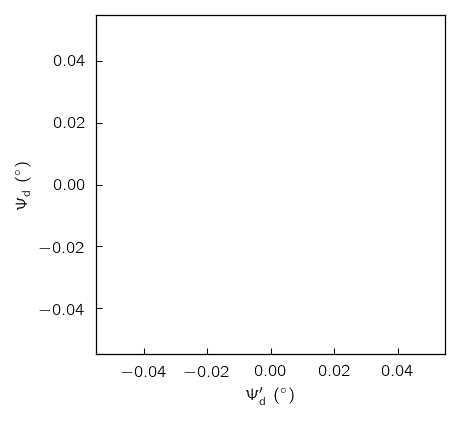

In [29]:
plt.plot()
plt.ylabel(latex_lab['detach2'])
plt.xlabel(latex_lab['detach1'])

In [52]:
str_dic = {
    #1
    #'corr_cont': np.array(['pmf', 'native_all']),
    #'contacts': np.array(['All', 'non-native']),
    #2
    'SI': np.array(['beta', 'alpha', 'betac', 'alphac']),
    'water': np.array(['R_com', 'Q_Bagchi', 'Nwater(Interface)', 'Shared Nwater(Interface)']),
    'angles': np.array(['phi-alpha(me)', 'phi-beta(me)', 'phi-open', 'zip-Dist']),
    'detach': np.array(['detach1', 'detach2', 'Hbond', 'Hbridge']),

}

In [53]:
avg_df.keys()

Index(['q_k600_mem0', 'q_k600_mem1', 'w_us', 'phi-alpha', 'phi-alpha(me)',
       'phi-beta', 'phi-beta(me)', 'phi-open(ch1)', 'phi-open(ch2)', 'r_com',
       'theta', 'phi', 'Theta', 'Phi', 'Psi', 'Nwater(Interface)',
       'Shared Nwater(Interface)', 'R_com', 'CrossContact(7A)', 'zip-Dist',
       'phi-open', 'beta', 'alpha', 'gamma1', 'gamma2', 'betac', 'alphac',
       'gamma1c', 'gamma2c', 'zip-turn', 'zip-term', 'All', 'native',
       'semi-native', 'non-native', 'detach1', 'detach2', 'Q_Bagchi',
       'Hbond( 24-24' )', 'Hbond( 24-26' )', 'Hbond( 26-24' )',
       'Hbond( 26-26' )', 'Hbridge( 24-24' )', 'Hbridge( 24-26' )',
       'Hbridge( 26-24' )', 'Hbridge( 26-26' )', 'gammac', 'native_all',
       'state', 'flux', 'pmf', 'Hbond', 'Hbridge'],
      dtype='object')

In [54]:
q_smth = np.linspace(0, 1, 11)
q_quant = [0.1, 0.5, 0.9]
outcome_quant_avg_dic={}
for key, val in str_dic.items():
    outcome_quant_avg_dic[key] = np.zeros((len(val), len(q_smth)+1, len(q_quant)))
    for i0, q_tmp in enumerate(q_smth[:-1], 1):
        mask_tmp = (avg_df.loc[:, q_key]>q_tmp) & (avg_df.loc[:, q_key]<q_tmp+np.diff(q_smth)[0])
        arr = avg_df.loc[mask_tmp, val].to_numpy()
        for i1 in range(len(val)):
            outcome_quant_avg_dic[key][i1, i0, :] = weighted_quantile(arr[:, i1], quantiles=q_quant, sample_weight=avg_df.loc[mask_tmp, 'flux'].to_numpy())

for key, val in str_dic.items():
    for i0 in range(len(q_quant)):
        outcome_quant_avg_dic[key][:, [0, -1], i0] = avg_df.loc[[0, k_tmp-1], val].to_numpy().T

In [55]:
q_smth

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [56]:
print(outcome_quant_avg_dic['corr_cont'][1][5:7,1].sum()/2)
print(outcome_quant_avg_dic['contacts'][1][5:7,1].sum()/2)

print(outcome_quant_avg_dic['corr_cont'][1][:,1])
print(outcome_quant_avg_dic['contacts'][1][:,1])

KeyError: 'corr_cont'

In [ ]:
outcome_quant_avg_dic['corr_cont'][1][5:7,1].sum()/2

In [57]:
stofint = np.hstack(list(stid_cg.values()))
stofnon = np.ones(k_tmp, dtype=bool)
stofnon[stofint] = False

In [58]:
np.array(list(stid_cg.items()), dtype=object)[[3, 2, 0, 1, 4, 7, 8, 5, 6, 9]]

array([['IS-twisted',
        array([  7,  51,  88, 100, 110, 117, 129, 204, 264, 277, 289, 372, 426,
               440, 474, 530])                                                 ],
       ['IS-splayed',
        array([ 55,  70,  95, 112, 166, 295, 302, 318, 335, 352, 388, 409, 431,
               454, 473, 481, 513, 525, 535, 543, 570, 571, 572])              ],
       ['IS-unzipped_up', array([305, 484])],
       ['IS-unzipped_down', array([506])],
       ['IS-rev-twisted', array([181, 230, 253])],
       ['TS-twisted', array([254, 447, 542])],
       ['TS-splayed', array([113, 256, 275, 279])],
       ['TS-unzipped_up', array([  3,  64, 108, 167, 449, 483])],
       ['TS-unzipped_down', array([ 17, 178, 393])],
       ['TS-rev-twisted',
        array([140, 194, 223, 238, 413, 501, 514, 568])]], dtype=object)

In [61]:
title_loc

'/project/dinner/kjeong/insulin/pipeline/step7_5ns/figure/step7_EP_SI'

/project/dinner/kjeong/insulin/pipeline/step7_5ns/figure/step7_EP_SI


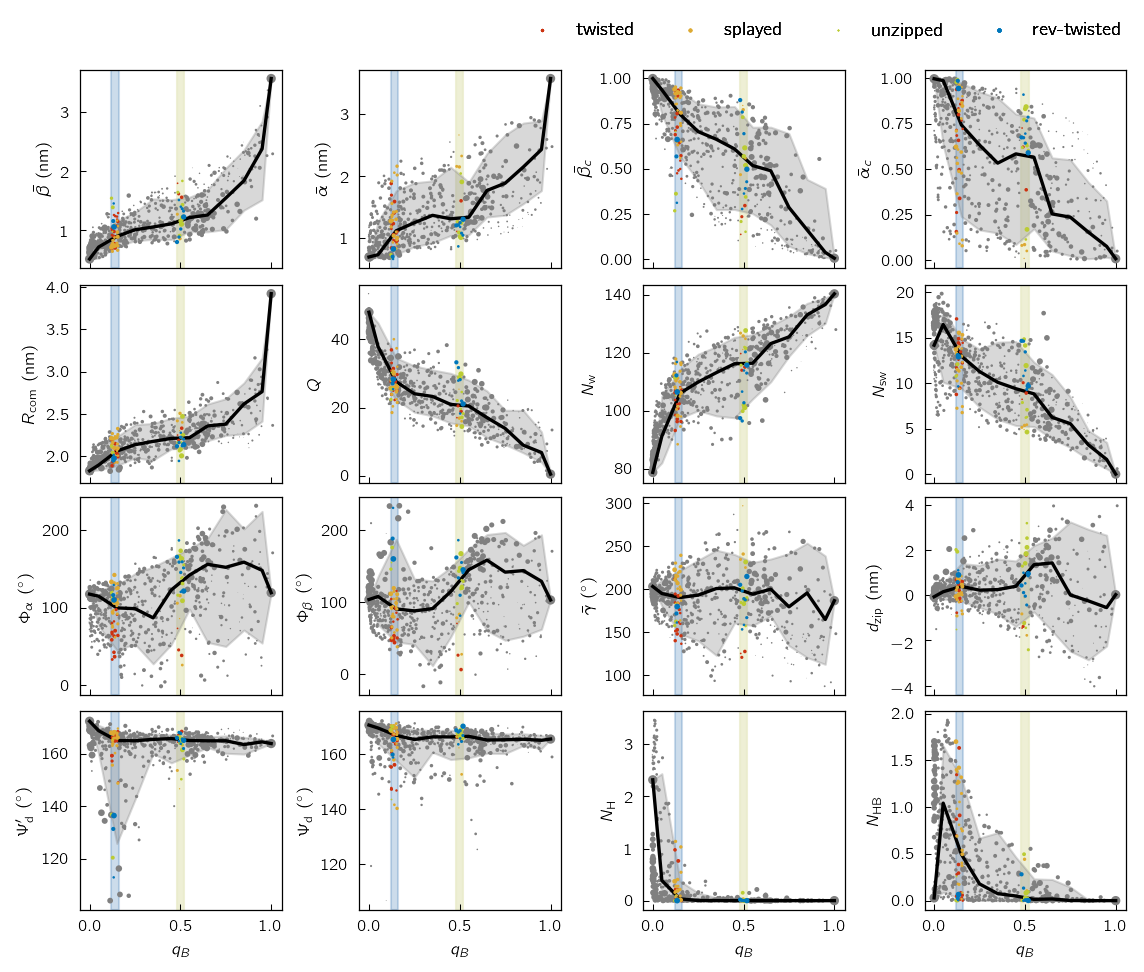

In [60]:
nrowcol = [len(val) for key, val in outcome_quant_avg_dic.items()]
nrow, ncol = len(nrowcol), max(nrowcol)
#vertical
#nrow, ncol = max(nrowcol), 1
#(4.45, 4)
#(7.2, 5)
#fig_width, fig_height = 4.45, 4
fig_width, fig_height = 7.5, 6

#horizontal
#fig_width = 3.6#7.2
#fig_height=2

fig, axs = plt.subplots(nrow, ncol, figsize=(fig_width, fig_height), constrained_layout=True, sharex=True)#, sharey=True)
q_xseq = np.hstack(([0], (q_smth[1:]+q_smth[:-1])/2, [1]))
if len(axs.shape)==1:
    axs = axs.reshape(1, len(axs))
for ir, key in enumerate(str_dic.keys()):
    for ic, (arr, ystr) in enumerate(zip(outcome_quant_avg_dic[key], str_dic[key])):
        ax = axs[ir, ic]
        ax.axvspan(*is_range, color=is_color, alpha=0.3, zorder=0)
        ax.axvspan(*ts_range, color=ts_color, alpha=0.8, zorder=0)
        ax.fill_between(q_xseq, arr[:,0], arr[:, 2], alpha=0.3, color='grey', zorder=5)
        
        ax.plot(q_xseq, arr[:,1], 'black', linewidth=1.6, zorder=15)
        ax.scatter(avg_df.loc[stofnon, q_key], avg_df.loc[stofnon, ystr], s = avg_df.loc[stofnon, 'flux']*20, color='gray', zorder=10, linewidth=0)
        for key, mask_cg in np.array(list(stid_cg.items()), dtype=object)[[3, 2, 0, 1, 4, 7, 8, 5, 6, 9]]:
            key2 = key.split('-')[1].split('_')[0]
            if not key2 in colors_cg.keys():
                key2 = key2+'-twisted'
            color_tmp = colors_cg[key2]
            if ir==0 and ic==0 and 'IS' in key:
                if (key2 == 'unzipped') and ('up' in key):
                    label = None
                else:
                    label=key2
            else:
                label = None
            ax.scatter(avg_df.loc[mask_cg, q_key], avg_df.loc[mask_cg, ystr], s = avg_df.loc[mask_cg, 'flux']*20, color=color_tmp, zorder=25, label=label, linewidth=0)
        ylab = latex_lab[ystr] if ystr in latex_lab.keys() else ystr
        ax.set_ylabel(ylab)
        if ir == nrow-1:
            ax.set_xlabel(latex_lab["qf"])

    if i_t==1:
        lgd=fig.legend(bbox_to_anchor=(-2.03, 0.85, 3.035, 0.215), bbox_transform=fig.transFigure, ncol=4, fontsize=9)
title_loc = f"{workdir}/figure/step7_EP_{list(str_dic.keys())[0]}"
print(title_loc)

#plt.savefig(f"{title_loc}_cm2.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig(f"{title_loc}_green.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')

## First Entrance committor

In [37]:
stid_cg_sym = []
cg_flux_lab = []
for key, tmp in stid_cg.items():
    if 'unzipped' in key:
        key_z = key.split("_")[0]
        if '_up' in key:
            cg_flux_lab.append(key_z[3:])
            stid_cg_sym.append(np.hstack((tmp, stid_cg[f"{key_z}_down"])))
    else:
        cg_flux_lab.append(key[3:])
        stid_cg_sym.append(tmp)
cg_flux_lab = np.array(cg_flux_lab)    

tmp = np.load(f"{workdir}/step7_structure/output/step4_atpt/cg_flux1.npy")
cg_flux = (rate - 1/tmp)/rate

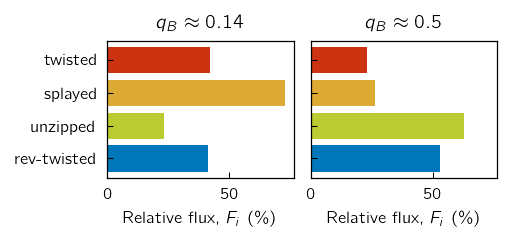

In [40]:
fig, axs = plt.subplots(1,2, figsize = (3.3, 1.5), constrained_layout=True, sharey=True, sharex=True)
tse_id2 = [8, 9]
tse_id = [7, 4, 6, 5]
ise_id = [3, 0, 1, 2]
#axs[1].barh(cg_flux_lab[tse_id2], 100*cg_flux[tse_id2], color = [colors_cg[key] for key in cg_flux_lab[tse_id2]], alpha=0.3, )
axs[1].barh(cg_flux_lab[tse_id], 100*cg_flux[tse_id], color = [colors_cg[key] for key in cg_flux_lab[tse_id]])
axs[0].barh(cg_flux_lab[ise_id], 100*cg_flux[ise_id], color = [colors_cg[key] for key in cg_flux_lab[ise_id]])
axs[0].set_title(r"$q_{B} \approx 0.14$")
axs[1].set_title(r"$q_{B} \approx 0.5$")
axs[0].set_xlabel(r"Relative flux, $F_{i}$ (\%)")
axs[1].set_xlabel(r"Relative flux, $F_{i}$ (\%)")
title_loc = f"{workdir}/figure/step7_relflux_noextra_2_cm.pdf"
plt.savefig(title_loc)

In [41]:
cg_traj = -np.ones(ntraj*length, dtype=np.int8)
cg_traj_lab = []
#n_meta = len(cg_flux_lab[:-2])
n_meta = len(cg_flux_lab)
cg_traj[dim_arr] = 0
cg_traj[mon_arr] = n_meta+1

cg_traj_lab.append("Dimer")
cnt = 1
#for key, arr in zip(cg_flux_lab[:-2], stid_cg_sym[:-2]):
for key, arr in zip(cg_flux_lab, stid_cg_sym):
    cg_traj_lab.append(f"{key}")
    cg_traj[np.isin(st_arr, arr)] = cnt
    cnt +=1
cg_traj_lab.append("Monomer")
cg_traj = cg_traj.reshape((ntraj, length))


In [42]:
#traj_id = np.nonzero(np.any((cg_traj>0) & cg_traj<n_meta+1, axis=1))[0]
traj_id = np.nonzero(np.any(cg_traj >= 0, axis=1))[0]
frame_id= cg_traj[traj_id]>=0
print(cg_traj[traj_id].shape)
cg_trans = [cg_traj[traj_id][i0, frame_tmp] for i0, frame_tmp in enumerate(frame_id)]


(14229, 1000)


In [43]:
CG_CM = np.zeros((n_meta+2, n_meta+2), dtype=int)
G_matrix = np.zeros((n_meta+2, n_meta+2), dtype=int)
for cg_tran in cg_trans:
    cg_tran_uq, cg_tran_cnt = np.unique(np.vstack((cg_tran[1:], cg_tran[:-1])), axis=1, return_counts=True)
    for i0, (i_row, i_col) in enumerate(cg_tran_uq.T):
        CG_CM[i_row, i_col] += cg_tran_cnt[i0]
        if i_row != i_col:
            G_matrix[i_row, i_col] += cg_tran_cnt[i0]
G_matrix = (G_matrix.T/np.sum(G_matrix, axis=1)).T
#CG_TM_f = (CG_CM.T/np.sum(CG_CM, axis=1)).T
    

In [44]:
id_order = np.array([
    0, #Dimer
    3, 2, 1, 4, #
    6, 7, 5, 8, #10, 9, 
    n_meta+1 #Monomer
])

In [55]:
plt.rcParams["text.latex.preamble"] = r'\usepackage{siunitx}\sisetup{detect-all}\usepackage{cmbright}\usepackage{amsfonts}'

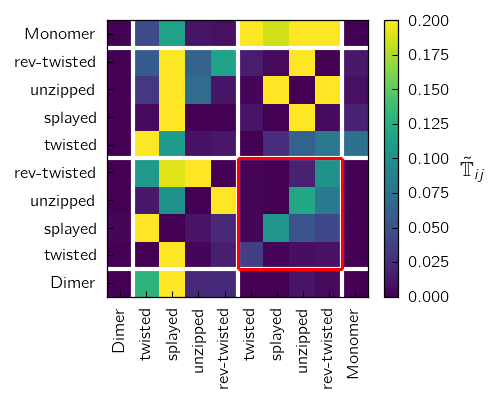

In [94]:
fig, ax = plt.subplots(1, 1, figsize=(2.8, 2.44))
#pc = ax.pcolor(CG_CM[id_order][:, id_order], vmax=1000)
pc = ax.pcolor(G_matrix[id_order][:, id_order], vmax=0.2, vmin=0.0)

ax.hlines(xmin=0, xmax=n_meta+2, y=[1, 9], color='white', linewidth=2, linestyles='-')
ax.vlines(ymin=0, ymax=n_meta+2, x=[1, 9], color='white', linewidth=2, linestyles='-')

ax.hlines(xmin=0, xmax=n_meta+2, y=5, color='white', linewidth=2, linestyles='-')
ax.vlines(ymin=0, ymax=n_meta+2, x=5, color='white', linewidth=2, linestyles='-')


ax.vlines(ymin=1, ymax=5, x=[5, n_meta+1], color='red', linewidth=1.5, linestyles='-')
ax.hlines(xmin=5, xmax=n_meta+1, y=[1,5], color='red', linewidth=1.5, linestyles='-')

#Use the labels to set the ticks
ax.set_xticks(np.arange(len(id_order))+0.5)
ax.set_yticks(np.arange(len(id_order))+0.5)
xlab = ax.set_xticklabels(np.array(cg_traj_lab)[id_order], rotation=90)
ylab = ax.set_yticklabels(np.array(cg_traj_lab)[id_order])
#make colorbar
pc = plt.colorbar(pc, ax=ax, location='right')
pclab = pc.set_label(r"$\tilde{\mathbb{T}}_{ij}$", fontsize=10, rotation=0,labelpad=10)
title_loc = f"{workdir}/figure/step7_Gmatrix_noextra_square_cm.pdf"
plt.savefig(title_loc, bbox_extra_artists=(*xlab, *ylab), bbox_inches='tight')

In [433]:
id_order_ise = id_order[1:5]
id_order_tse = id_order[5:-1]

In [347]:
import sys
sys.path.append("/project/dinner/kjeong/pkg")
sys.path.append("/project/dinner/kjeong/pkg/pySankey")
from pySankey.pysankey import sankey
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

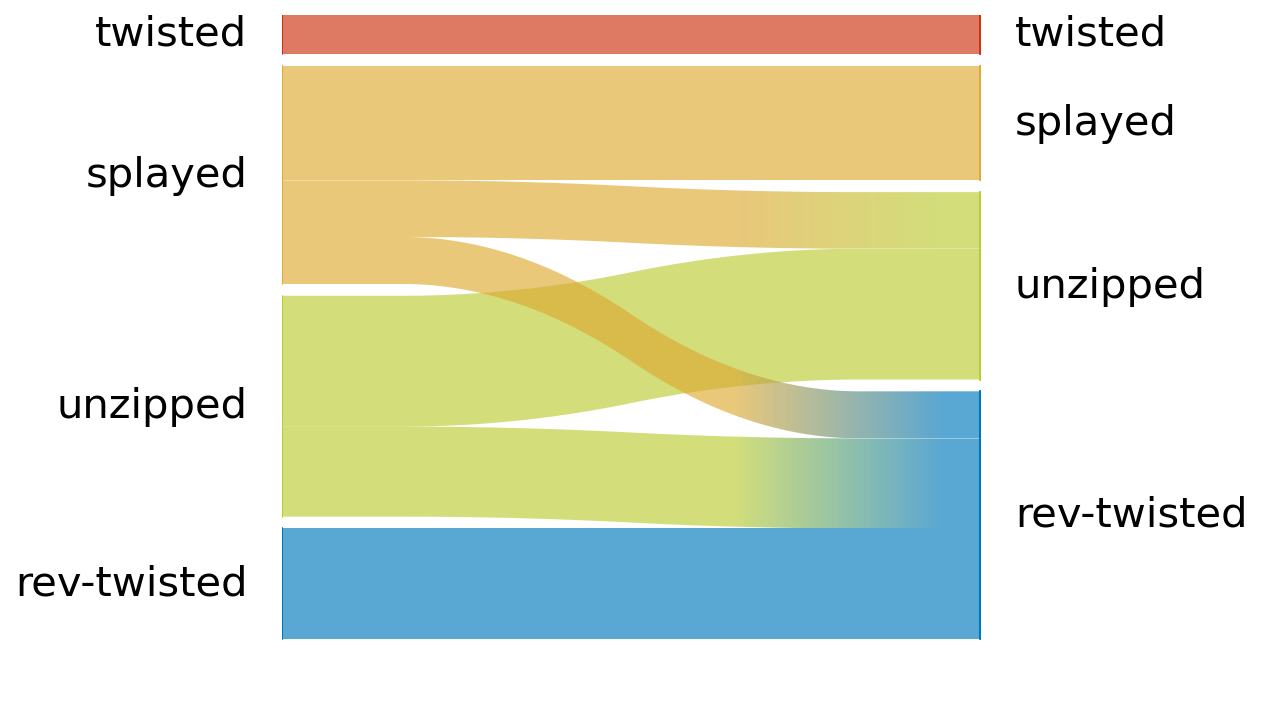

In [436]:
arr_tmp = G_matrix[id_order_ise[::-1]][:, id_order_tse[::-1]]#G_trans
lab0_tmp = np.array(cg_traj_lab)[id_order_ise[::-1]]
lab1_tmp = np.array(cg_traj_lab)[id_order_tse[::-1]]

nonz_tmp = np.nonzero(arr_tmp>0.02)
#arr_tmp = (arr_tmp.T*cg_df.loc[lab0_tmp, 'flux'].to_numpy()).T
#arr_tmp = arr_tmp
sankey(
    left=lab0_tmp[nonz_tmp[0]], right=lab1_tmp[nonz_tmp[1]], 
    leftWeight= arr_tmp[nonz_tmp], rightWeight=arr_tmp[nonz_tmp], 
    leftLabels= lab0_tmp, rightLabels=lab1_tmp, 
    colorDict = colors_cg, gradColor=True,
    aspect=20, fontsize=20
)

title_loc = f"{workdir}/figure/step7_sankey_noextra.pdf"
plt.savefig(title_loc)

# Contacts

In [95]:
with open(f"{workdir}/step7_structure/output/step3_contactmaps/Allcontact_resid.pkl", 'rb') as f:
    resid_contact = dill.load(f)

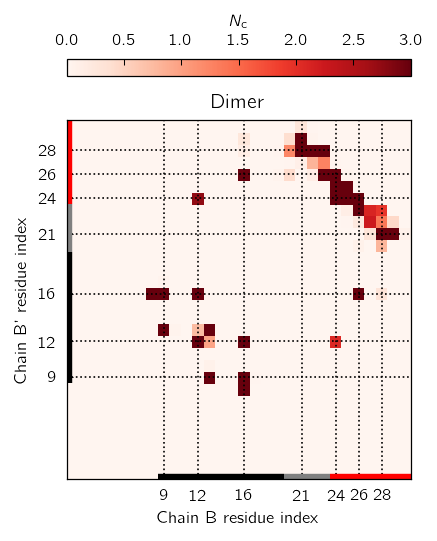

In [99]:
ncol = 1
nrow = 1
fig, ax = plt.subplots(nrow, ncol, figsize=(2.8, 3.5), constrained_layout=True)
arr = resid_contact["CG_state"]["Dimer"]
pc = ax.pcolor(arr[21:, 21:], cmap='Reds', rasterized=True, vmax=3)#, vmax=3

ax.hlines(0, xmin=8, xmax=19, linewidth=5, color='black')
ax.hlines(0, xmin=19, xmax=23, linewidth=5, color='gray')
ax.hlines(0, xmin=23, xmax=30, linewidth=5, color='red')

ax.vlines(0, ymin=8, ymax=19, linewidth=5, color='black')
ax.vlines(0, ymin=19, ymax=23, linewidth=5, color='gray')
ax.vlines(0, ymin=23, ymax=30, linewidth=5, color='red')


ax.set_title("Dimer")
ticks = np.array([9, 12, 16, 21, 24, 26, 28])
ax.set_xticks(ticks-0.5)
ax.set_xticklabels(ticks)
ax.set_yticks(ticks-0.5)
ax.set_yticklabels(ticks)
#mamke grid lines
ax.grid(":", c='black', linewidth=0.8, ls=":")
cb = plt.colorbar(pc, ax=ax, location='top')
cb.set_label(label=r"$N_{\rm c}$")

ax.set_ylabel("Chain B' residue index")
ax.set_xlabel("Chain B residue index")
#plt.savefig(f"{workdir}/figure/step7_CM_dim_cm.pdf", dpi=580)

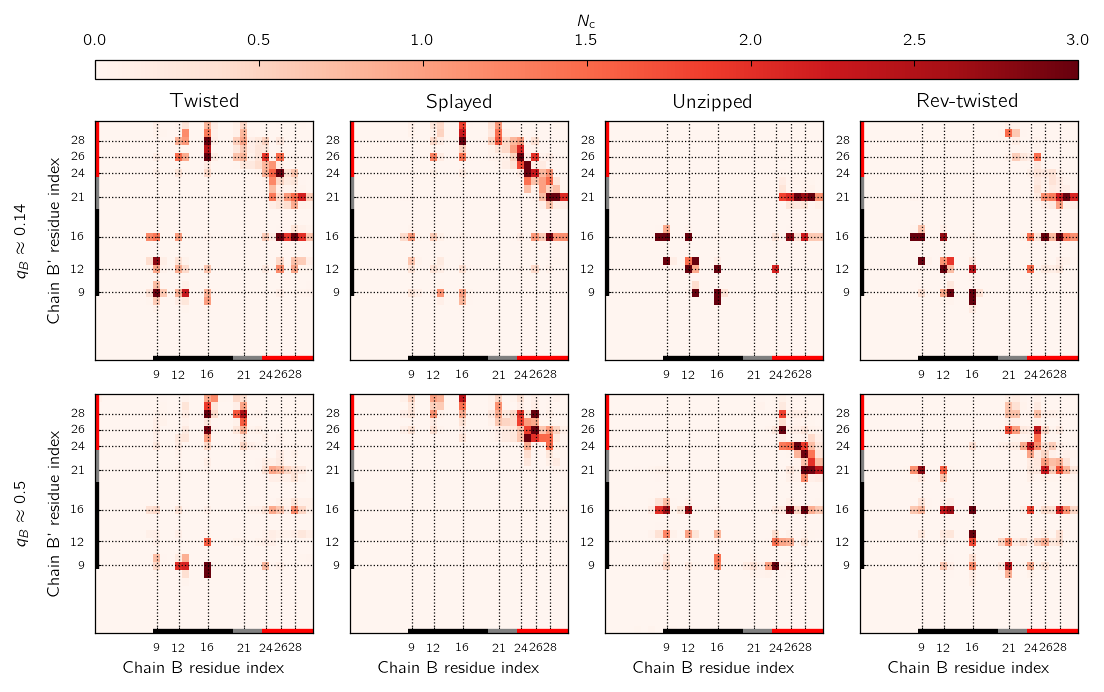

In [120]:
nrow = 2
ncol = 4
fig, axs = plt.subplots(nrow, ncol, figsize=(7.25, 4.5), constrained_layout=True)
arrs = {key: resid_contact["CG_state"][key] for key in resid_contact["CG_state"].keys() if not key in ["Dimer"]}

id_ls = ['twist', 'rev', 'open', 'zip']
for key, arr in resid_contact["CG_state"].items():
    if "IS" in key:
        ir = 0
    elif "TS" in key:
        ir = 1
    else:
        continue
    
    if ("twisted" in key) and (not "rev" in key): 
        ic = 0
        title = 'Twisted'
    elif "splayed" in key:
        ic = 1
        title = 'Splayed'
    elif "unzipped_up" in key:
        ic = 2
        title = 'Unzipped'
    elif "rev-twisted" in key:
        ic = 3
        title = 'Rev-twisted'
    else:
        continue
    ax = axs[ir, ic]
    pc = ax.pcolor(arr[21:, 21:], cmap='Reds', vmax= 3, rasterized=True)
    ticks = np.array([9, 12, 16, 21, 24, 26, 28])
    if ir == 0:
        ax.set_title(title)
    ax.set_yticks(ticks-0.5)
    ax.set_yticklabels(ticks, fontsize=6.0)
    ax.set_xticks(ticks-0.5)
    ax.set_xticklabels(ticks, fontsize=6.0)
    ax.grid(":", c='black', linewidth=0.6, ls=":")
    ax.hlines(0, xmin=8, xmax=19, linewidth=4, color='black')
    ax.hlines(0, xmin=19, xmax=23, linewidth=4, color='gray')
    ax.hlines(0, xmin=23, xmax=30, linewidth=4, color='red')

    ax.vlines(0, ymin=8, ymax=19, linewidth=4, color='black')
    ax.vlines(0, ymin=19, ymax=23, linewidth=4, color='gray')
    ax.vlines(0, ymin=23, ymax=30, linewidth=4, color='red')
    if ir ==1:
        ax.set_xlabel("Chain B residue index")

#Reduce the blank space between colorbar and plots

cb = plt.colorbar(pc, ax=axs.ravel().tolist(), location='top', pad=0.03, aspect=50)
cb.set_label(label=r"$N_{\rm{c}}$")

axs[0,0].set_ylabel(r"$q_{B}\approx 0.14$"+"\n\nChain B' residue index")
axs[1,0].set_ylabel(r"$q_{B}\approx 0.5$"+"\n\nChain B' residue index")
#plt.savefig(f"{workdir}/figure/step7_CM_CG_cm.pdf", dpi=580)

In [12]:
with open(f"{workdir}/step7_structure/output/step3_contactmaps/Allcontact_atom.pkl", 'rb') as f:
    atom_contact = dill.load(f)

In [13]:
import MDAnalysis as mda

#Define atom2res shape: (51, 2) with index where each residue starts and ends
univ = mda.Universe("/beagle3/dinner/kjeong/Insulin_md/input/parm/charmm-gui-3w7y-dimer-ins/step3_pbcsetup.pdb")
ags = univ.select_atoms('protein and not (same mass as (name HA))')
residues_id = ags.resids[:405] - 1
residues_id[ags.segids[:405]=='PROB'] += 21
_, atom2res = np.unique(residues_id, return_index=True)
atom2res = np.hstack([atom2res, [len(residues_id)]])
atom2res = np.vstack([atom2res[:-1], atom2res[1:]]).T

/project/dinner/kjeong/anaconda3/lib/python3.9/site-packages/MDAnalysis/topology/PDBParser.py:328: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "


In [161]:
atom2res[21:][8]

array([226, 232])

In [27]:
np.linspace(0, 10, 11)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [165]:
atom2res[21]

array([163, 174])

In [168]:
print(atom2res[21:][[8, 18]])#B9-19
print(atom2res[21:][[19, 22]])#turn 20--23)
print(atom2res[21:][23:])#turn 24--
#first residue on Bchian starts from atom index 163 residue index 21

[[226 232]
 [306 312]]
[[312 316]
 [336 340]]
[[340 351]
 [351 362]
 [362 374]
 [374 381]
 [381 388]
 [388 397]
 [397 405]]


In [189]:
atom2res[21:][np.array([9, 12, 16, 21, 24, 26, 28])-1]

array([[226, 232],
       [250, 257],
       [279, 291],
       [316, 325],
       [340, 351],
       [362, 374],
       [381, 388]])

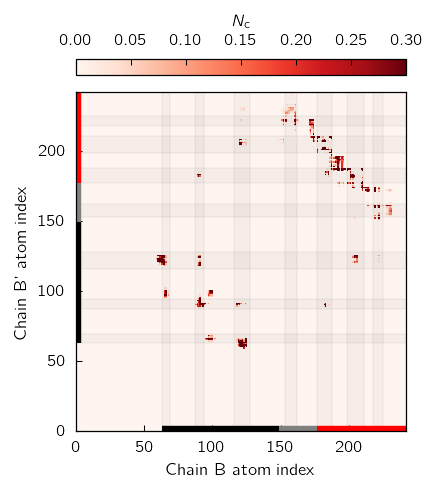

In [26]:
ncol = 1
nrow = 1
fig, ax = plt.subplots(nrow, ncol, figsize=(2.8, 3.18), constrained_layout=True)
arr = atom_contact["CG_state"]["Dimer"].todense()
pc = ax.pcolor(arr[163:, 163:], cmap='Reds', rasterized=True, vmax=0.3)#, vmax=3
ax.hlines(0, xmin=226-163, xmax=312-163, linewidth=5, color='black')
ax.hlines(0, xmin=312-163, xmax=340-163, linewidth=5, color='gray')
ax.hlines(0, xmin=340-163, xmax=405-163, linewidth=5, color='red')

ax.vlines(0, ymin=226-163, ymax=312-163, linewidth=5, color='black')
ax.vlines(0, ymin=312-163, ymax=340-163, linewidth=5, color='gray')
ax.vlines(0, ymin=340-163, ymax=405-163, linewidth=5, color='red')

for range_tmp in atom2res[21:][np.array([9, 12, 16, 21, 24, 26, 28])-1]:
    ax.axvspan(range_tmp[0]-163, range_tmp[1]-163, color='black', alpha=0.03)
    ax.axhspan(range_tmp[0]-163, range_tmp[1]-163, color='black', alpha=0.03)
"""
title("Dimer")
ticks = np.array([9, 12, 16, 21, 24, 26, 28])
ax.set_xticks(ticks-0.5)
ax.set_xticklabels(ticks)
ax.set_yticks(ticks-0.5)
ax.set_yticklabels(ticks)
#mamke grid lines
ax.grid(":", c='black', linewidth=0.8, ls=":")
"""
cb = plt.colorbar(pc, ax=ax, location='top')
cb.set_label(label=r"$N_{\rm c}$")

ax.set_ylabel("Chain B' atom index")
ax.set_xlabel("Chain B atom index")
plt.savefig(f"{workdir}/figure/step7_CM_atom_dimer_cm.pdf", dpi=580)

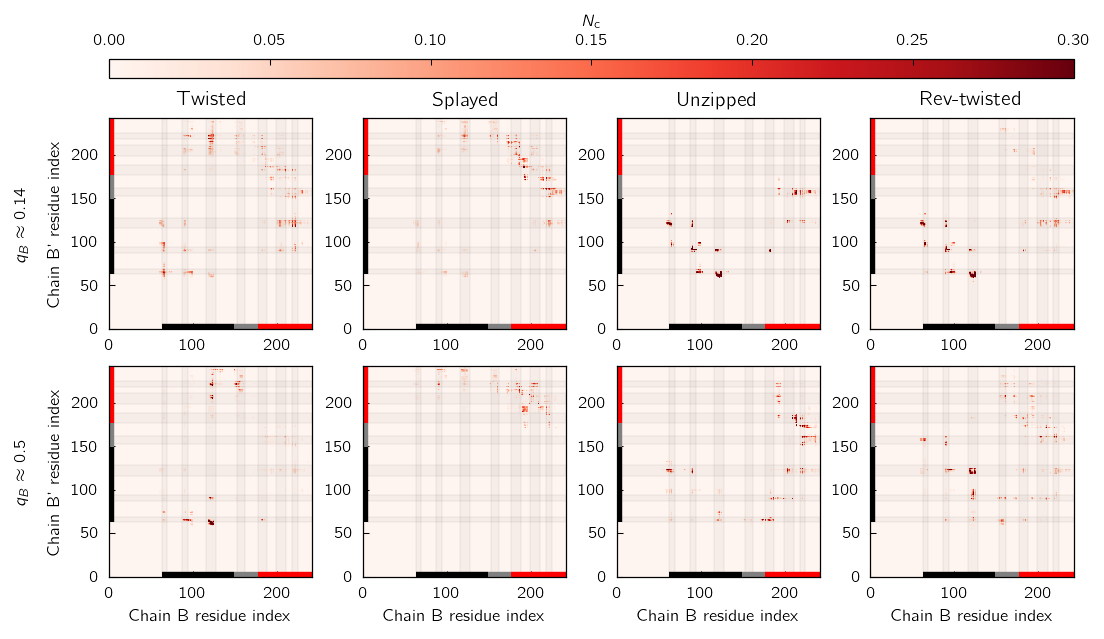

In [25]:
nrow = 2
ncol = 4
fig, axs = plt.subplots(nrow, ncol, figsize=(7.25, 4.15), constrained_layout=True)

id_ls = ['twist', 'rev', 'open', 'zip']
for key, arr in atom_contact["CG_state"].items():
    if "IS" in key:
        ir = 0
    elif "TS" in key:
        ir = 1
    else:
        continue
    
    if ("twisted" in key) and (not "rev" in key): 
        ic = 0
        title = 'Twisted'
    elif "splayed" in key:
        ic = 1
        title = 'Splayed'
    elif "unzipped_up" in key:
        ic = 2
        title = 'Unzipped'
    elif "rev-twisted" in key:
        ic = 3
        title = 'Rev-twisted'
    else:
        continue
    ax = axs[ir, ic]
    arr = arr.todense()
    pc = ax.pcolor(arr[163:, 163:], cmap='Reds', vmax= 0.3, rasterized=True)
    ticks = np.array([9, 12, 16, 21, 24, 26, 28])
    if ir == 0:
        ax.set_title(title)
    """
    ax.set_yticks(ticks-0.5)
    ax.set_yticklabels(ticks, fontsize=6.0)
    ax.set_xticks(ticks-0.5)
    ax.set_xticklabels(ticks, fontsize=6.0)
    
    ax.grid(":", c='black', linewidth=0.6, ls=":")
    """


    for range_tmp in atom2res[21:][np.array([9, 12, 16, 21, 24, 26, 28])-1]:
        ax.axvspan(range_tmp[0]-163, range_tmp[1]-163, color='black', alpha=0.03)
        ax.axhspan(range_tmp[0]-163, range_tmp[1]-163, color='black', alpha=0.03)
        
    ax.hlines(0, xmin=226-163, xmax=312-163, linewidth=5, color='black')
    ax.hlines(0, xmin=312-163, xmax=340-163, linewidth=5, color='gray')
    ax.hlines(0, xmin=340-163, xmax=405-163, linewidth=5, color='red')

    ax.vlines(0, ymin=226-163, ymax=312-163, linewidth=5, color='black')
    ax.vlines(0, ymin=312-163, ymax=340-163, linewidth=5, color='gray')
    ax.vlines(0, ymin=340-163, ymax=405-163, linewidth=5, color='red')


    if ir ==1:
        ax.set_xlabel("Chain B residue index")

#Reduce the blank space between colorbar and plots

cb = plt.colorbar(pc, ax=axs.ravel().tolist(), location='top', pad=0.03, aspect=50)
cb.set_label(label=r"$N_{\rm{c}}$")

axs[0,0].set_ylabel(r"$q_{B}\approx 0.14$"+"\n\nChain B' residue index")
axs[1,0].set_ylabel(r"$q_{B}\approx 0.5$"+"\n\nChain B' residue index")
plt.savefig(f"{workdir}/figure/step7_CM_atom_CG_cm.pdf", dpi=580)